## Load

In [136]:
import pandas as pd
data = pd.read_csv('dataset.tsv', sep='\t', index_col=0)

In [137]:
data.clean_text = data.clean_text.apply(eval)
data.bow = data.bow.apply(eval)
data.entities = data.entities.apply(eval)

In [143]:
data['len'] = data['clean_text'].apply(len)

In [144]:
data = data[data.len>0]

In [145]:
data.index = pd.Index(list(range(len(data))))

## LDA features

In [146]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LdaMulticore

In [147]:
import numpy as np

In [148]:
def document_to_lda_features_by_word(lda_model, dictionary, document):
    if len(document)==0:
        return np.zeros(lda_model.num_topics, dtype="float32").reshape(1, lda_model.num_topics)
    featureVec = np.array(LDAmodel.get_document_topics(
        dictionary.doc2bow([document[0]]), minimum_probability=0))[:,1].reshape(1, lda_model.num_topics)
    for word in document[1:]:
        featureVec = np.vstack([featureVec,
                                np.array(LDAmodel.get_document_topics(
                                    dictionary.doc2bow([word]), minimum_probability=0))[:,1]])
    return featureVec

In [149]:
dictionary = Dictionary(documents=data.clean_text.values)
print("Found {} words.".format(len(dictionary.values())))
data['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), data.clean_text))
corpus = data.bow

Found 1882 words.


/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [150]:
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=400,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [151]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [152]:
lengths = data['clean_text'].apply(len).sort_values(ascending=False)
sorted_idx = lengths[lengths>0].index
seq_tensor = nn.utils.rnn.pad_sequence(tuple(data.loc[sorted_idx]['clean_text'].apply(lambda x: 
                                                                    torch.FloatTensor(
                                                                    #    get_w2v_features_by_word(W2Vmodel, x)
                                                                        torch.from_numpy(document_to_lda_features_by_word(LDAmodel, dictionary, x)).float()
                                                                    ))))
lengths = lengths[lengths>0].values

In [153]:
X_lda_packed = nn.utils.rnn.pack_padded_sequence(seq_tensor, lengths)

In [154]:
num_topics = 400
output_size = 64

In [155]:
lstm = nn.LSTM(num_topics, output_size, bidirectional=True, num_layers=1)
packed_output, (ht, ct) = lstm(X_lda_packed)
output, _ = nn.utils.rnn.pad_packed_sequence(packed_output)

In [159]:
data['bilstm'] = pd.Series(list(ht[-1].detach().numpy()[pd.DataFrame(sorted_idx).sort_values(0).index]))

## BASELINE

In [160]:
gold_X = np.array(list(map(np.array, data.bilstm)))
gold_y = data['intent']

In [161]:
from collections import Counter

In [162]:
Counter(gold_y).most_common()[-1]

('fallback', 96)

In [167]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

def balanced_sample_maker(X, y, sample_size=None, random_seed=36):
    uniq_levels = np.unique(y)
    uniq_counts = {level: sum(y == level) for level in uniq_levels}

    if not sample_size:
        sample_size = round(min(uniq_counts.values()))
        print(sample_size)
    
    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
    # oversampling on observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.items():
        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=False).tolist()
        balanced_copy_idx+=over_sample_idx
    np.random.shuffle(balanced_copy_idx)

    left_idx = [i for i in range(len(X)) if i not in balanced_copy_idx]
    
    data_train=X[balanced_copy_idx]
    labels_train=y[balanced_copy_idx]
    
    data_test=X[left_idx]
    labels_test=y[left_idx]
    
    if  ((len(data_train)) == (sample_size*len(uniq_levels))):
        print('number of sampled example ', sample_size*len(uniq_levels), 'number of sample per class ', sample_size, ' #classes: ', len(list(set(uniq_levels))))
    else:
        print('number of samples is wrong ')

    labels, values = zip(*Counter(labels_train).items())
    print('number of classes ', len(list(set(labels_train))))
    check = all(x == values[0] for x in values)
    print(check)
    if check == True:
        print('Good all classes have the same number of examples')
    else:
        print('Repeat again your sampling your classes are not balanced')
    indexes = np.arange(len(labels))
    width = 0.5
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()
    return data_train,labels_train, data_test, labels_test

number of sampled example  760 number of sample per class  38  #classes:  20
number of classes  20
True
Good all classes have the same number of examples


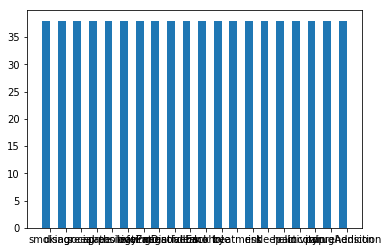

In [164]:
gold_X_test, gold_y_test, gold_X_train, gold_y_train =balanced_sample_maker(gold_X, 
                                                                             gold_y, int(96*0.4))

58
number of sampled example  1160 number of sample per class  58  #classes:  20
number of classes  20
True
Good all classes have the same number of examples


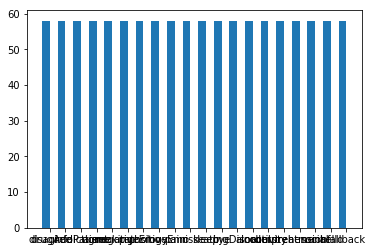

In [168]:
gold_balanced_X_train, gold_balanced_y_train, _, _ = balanced_sample_maker(gold_X_train, 
                                                                              gold_y_train.values)

In [169]:
gold_test_inx = gold_y_test.index

In [170]:
gold_X = np.array(list(map(np.array, data.bilstm)))
gold_y = data['intent']

In [171]:
gold_train_data = data.drop(gold_test_inx, errors="ignore")[['bilstm', 'intent']]
gold_test_data = data.loc[gold_test_inx][['bilstm', 'intent']]

In [173]:
gold_X_train = np.array(list(map(np.array, gold_train_data.bilstm)))
gold_y_train = gold_train_data['intent']
gold_X_test = np.array(list(map(np.array, gold_test_data.bilstm)))
gold_y_test = gold_test_data['intent']

### RF

In [174]:
from sklearn.ensemble import RandomForestClassifier

In [175]:
clf = RandomForestClassifier().fit(gold_X_train, gold_y_train)

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [176]:
clf.score(gold_X_test, gold_y_test)

0.3526315789473684

In [177]:
clf = RandomForestClassifier().fit(gold_balanced_X_train, gold_balanced_y_train)

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [178]:
clf.score(gold_X_test, gold_y_test)

0.31973684210526315

### SVC

In [179]:
from sklearn.svm import SVC

In [180]:
clf = SVC(kernel='linear', C=1, random_state=0, probability=True).fit(gold_balanced_X_train, 
                                                                      gold_balanced_y_train)

In [181]:
clf.score(gold_X_test, gold_y_test)

0.20789473684210527

In [182]:
clf.predict(gold_X_test[:40])

array(['smoking', 'negativeEmo', 'negativeEmo', 'fallback', 'agree',
       'eatingDisorders', 'fallback', 'drugAddiction', 'drugAddiction',
       'fallback', 'fallback', 'fallback', 'drugAddiction', 'agree',
       'agree', 'eatingDisorders', 'smoking', 'treatment', 'fallback',
       'alcohol', 'social', 'alcohol', 'risk', 'activity', 'agree',
       'hello', 'infoPatient', 'fallback', 'drugAddiction',
       'drugAddiction', 'incomprehension', 'eatingDisorders',
       'drugAddiction', 'sleep', 'fallback', 'fallback', 'social', 'pain',
       'drugAddiction', 'disagree'], dtype=object)

### CV scores

In [183]:
from sklearn.model_selection import cross_validate

In [184]:
scores = cross_validate(clf, gold_X, gold_y, scoring='accuracy', cv=5, return_estimator=False)

In [185]:
print('{:2.3} + {:2.3}%'.format(np.mean(scores['train_score']), np.std(scores['train_score'])))

0.211 + 0.00902%


/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [186]:
print('{:2.3} + {:2.3}%'.format(np.mean(scores['test_score']), np.std(scores['test_score'])))

0.209 + 0.0332%


### confusion

In [188]:
X_bilstm = np.array(list(map(np.array, data.bilstm)))
data['label'] = clf.predict(X_bilstm)

In [145]:
data[data.label=='pain'][['intent', 'label', 'text', 'clean_text']]

,intent,label,text,clean_text
111,pathology,pain,I think i may have Anorexia,"[think, may, anorexia]"
205,sleep,pain,"if I were to jog for 10 minutes, then I have insomnia","[jog, _num_, minute, insomnia]"
340,sleep,pain,I slept yesterday night for around 6:30 hours,"[sleep, yesterday, night, around, _num_, hour]"
374,sleep,pain,I feel tired already after 11 a.m,"[feel, tire, already, _num_]"
420,eatingDisorders,pain,After lunch I have about 2 servings of fruit,"[lunch, _num_, serving, fruit]"
440,eatingDisorders,pain,i love to eat too much sweet,"[love, eat, much, sweet]"
601,drugAddiction,pain,Im at Meth currently,"[meth, currently]"
644,drugAddiction,pain,i had a very bad problem with pills,"[bad, problem, pill]"
915,pain,pain,I feel this pain every minute,"[feel, pain, every, minute]"
916,pain,pain,This pain was were since 4 years,"[pain, since, _num_, year]"


In [189]:
from sklearn.metrics import confusion_matrix

In [190]:
clf_res = pd.DataFrame([clf.predict(gold_X_test), gold_y_test]).T
clf_res.columns = ['class', 'intent']

In [191]:
cm = pd.DataFrame(confusion_matrix(clf_res['intent'], clf_res['class']), 
             index=clf.classes_, columns=clf.classes_)

In [ ]:
clf_res.groupby('class').count()

In [ ]:
clf_res.groupby('intent').count()

In [192]:
cm.style.set_table_styles(
    [dict(selector="th",props=[('max-width', '120px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(180deg)'),
                        ])]
).background_gradient(axis=1)

,activity,agree,alcohol,bye,disagree,drugAddiction,eatingDisorders,fallback,hello,incomprehension,infoPatient,negativeEmo,pain,pathology,positiveEmo,risk,sleep,smoking,social,treatment
activity,0,2,2,0,2,15,4,1,0,0,2,0,2,0,0,4,0,0,4,0
agree,2,9,0,0,1,0,0,15,8,1,0,0,1,0,1,0,0,0,0,0
alcohol,0,1,5,0,2,8,1,0,0,0,0,2,0,0,1,15,3,0,0,0
bye,4,3,0,5,1,3,1,14,1,0,0,1,1,0,0,0,0,0,4,0
disagree,0,0,0,0,6,2,0,22,4,0,0,2,0,0,0,0,0,0,2,0
drugAddiction,0,0,0,0,0,8,1,0,0,0,0,0,0,0,0,23,4,1,0,1
eatingDisorders,2,0,1,2,0,9,8,0,0,0,0,0,0,0,0,8,7,0,1,0
fallback,0,1,0,0,4,2,0,23,3,0,0,1,1,0,1,0,1,0,1,0
hello,0,8,0,3,2,1,0,14,10,0,0,0,0,0,0,0,0,0,0,0
incomprehension,0,2,0,1,2,16,2,3,3,4,0,0,0,1,0,1,3,0,0,0


# Label new data

In [193]:
new_data = pd.read_csv('filtered_tokenized_posts.tsv', sep='\t', index_col=0)

In [194]:
new_data = new_data.drop_duplicates()

In [195]:
new_data.clean_text = new_data.clean_text.apply(eval)

In [196]:
len(new_data)

380014

In [197]:
new_data['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), new_data.clean_text))

In [202]:
new_data['lens']= new_data.bow.apply(len)
new_data = new_data[(new_data.lens>2) & (new_data.lens < 7)]

In [203]:
len(new_data)

162984

In [210]:
new_lengths = new_data['clean_text'].apply(len).sort_values(ascending=False)
new_sorted_idx = new_lengths[new_lengths>0].index
new_seq_tensor = nn.utils.rnn.pad_sequence(tuple(new_data.loc[new_sorted_idx]['clean_text'].apply(lambda x: 
                                                                    torch.FloatTensor(
                                                                        torch.from_numpy(document_to_lda_features_by_word(LDAmodel, dictionary, x)).float()
                                                                    ))))
new_lengths = new_lengths.values

In [211]:
new_X_lda_packed = nn.utils.rnn.pack_padded_sequence(new_seq_tensor, new_lengths)

In [154]:
num_topics = 400
output_size = 64

In [212]:
_, (ht, _) = lstm(new_X_lda_packed)

In [213]:
new_data['bilstm'] = pd.Series(list(ht[-1].detach().numpy()[pd.DataFrame(new_sorted_idx).sort_values(0).index]))

In [204]:
new_data.index = pd.Index(list(range(len(new_data))))

In [418]:
new_data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      new_data.bow))

In [50]:
new_data.head()

,clean_text,text,bow,lens,lda_features
0,"[last, time, used, heroin]",When was the last time you used heroin ?,"[(92, 1), (101, 1), (294, 1)]",3,"[0.25476476550102234, 0.0038796178996562958, 0..."
1,"[get, truth, soon, enough]",We 'll get the truth soon enough .,"[(51, 1), (489, 1), (492, 1)]",3,"[0.004073598422110081, 0.003879617666825652, 0..."
2,"[also, psychiatrist, would, prescribe, pain, m...","\n\n Also , no , a psychiatrist would not pres...","[(119, 1), (389, 1), (512, 1), (537, 1), (555,...",6,"[0.15208354592323303, 0.002216924447566271, 0...."
3,"[would, tell, person, go, see, family, phycisian]",He / she would tell that person to go see th...,"[(11, 1), (119, 1), (167, 1), (710, 1), (1080,...",6,"[0.19251978397369385, 0.002216924447566271, 0...."
4,"[nt, one, woke, since, november, nt, bad]",I have n't had one that woke me since November...,"[(80, 1), (91, 1), (134, 1)]",3,"[0.004073598887771368, 0.0038796178996562958, ..."


In [214]:
X_new_lda = np.array(list(map(np.array, new_data.bilstm)))

In [215]:
new_data['prediction'] = clf.predict(X_new_lda)
new_data['proba'] = clf.predict_proba(X_new_lda).max(axis=1)

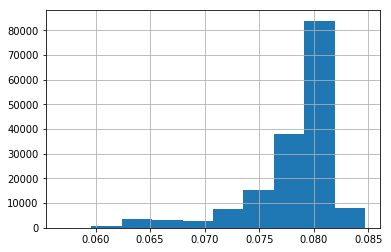

In [216]:
new_data.proba.hist()

In [218]:
pd.set_option('max_colwidth', 800)

In [220]:
Counter(sum(data[data.intent == 'sleep'].clean_text.values, [])).most_common(10)

[('sleep', 214),
 ('_num_', 154),
 ('wake', 62),
 ('night', 58),
 ('hour', 48),
 ('go', 40),
 ('feel', 40),
 ('fall', 32),
 ('asleep', 32),
 ('get', 30)]

In [219]:
new_data.sort_values('proba', ascending=False)[['text', 'proba', 'prediction', 'clean_text']]

,text,proba,prediction,clean_text
29191,\n\n bad bad bad habit i know ... Bad Sammy !,0.084719,risk,"[bad, bad, bad, habit, know, bad, sammy]"
67854,"Or did you continue to stay there through the "" 3 or 4 weeks until you felt human again "" ?",0.084657,risk,"[continue, stay, _num_, _num_, weeks, felt, human]"
136109,You need to stay on it 3 or 4 weeks before you can tell if it will work .,0.084502,risk,"[need, stay, _num_, _num_, weeks, tell, work]"
60461,It 's bad to become dependent on the pill to need to fall asleep .,0.084477,risk,"[bad, become, dependent, pill, need, fall, asleep]"
103168,"I can try to stay awake , but I know I will eventually have to sleep .",0.084458,risk,"[try, stay, awake, know, eventually, sleep]"
58937,"Try to stay strong , take it minute by minute if need be .",0.084453,risk,"[try, stay, strong, take, minute, minute, need]"
98813,I try to work out and be active to be tired at night and go to sleep .,0.084406,risk,"[try, work, active, tired, night, go, sleep]"
38238,Try to stay away from most of it for a few days and see if you feel better .,0.084395,risk,"[try, stay, away, days, see, feel, better]"
145971,I try to stay active as far as stretching and light cardio .,0.084378,risk,"[try, stay, active, far, stretching, light, cardio]"
120129,\n\n Try to stay away from spicey foods if you think it 's reflux .,0.084357,risk,"[try, stay, away, spicey, foods, think, reflux]"


In [424]:
new_data.prediction.unique()

array(['fallback', 'pain', 'sleep', 'bye', 'drugAddiction',
       'eatingDisorders', 'positiveEmo', 'agree', 'negativeEmo', 'hello',
       'activity', 'incomprehension', 'pathology', 'disagree', 'social',
       'treatment', 'alcohol', 'risk', 'infoPatient', 'smoking'],
      dtype=object)

In [221]:
set(data.intent.unique()) == set(new_data.prediction.unique())

False

In [223]:
new_data[new_data.prediction == 'pain']\
    .sort_values('proba', ascending=False)[['text', 'proba', 'clean_text']]

,text,proba,clean_text
34130,My pain is unbearable the way that it is now .,0.068296,"[pain, unbearable, way]"
99368,This was Christmas Eve by the way .,0.068296,"[christmas, eve, way]"
131216,stomach pain is not as bad .,0.068075,"[stomach, pain, bad]"
154253,"I have nicorette gum , so I 'll start with that .",0.068066,"[nicorette, gum, start]"
97880,I have been having this stomach pain for a year now .,0.068018,"[stomach, pain, year]"
66224,I have had no stomach pain since .,0.067591,"[stomach, pain, since]"
12464,\n\n Anybody else have the problem ? ?,0.067581,"[anybody, else, problem]"
146071,Anybody else with that problem ?,0.067581,"[anybody, else, problem]"
40447,"Physically though , I have a problem .",0.067581,"[physically, though, problem]"
76990,It was awful as i m sure you all know .,0.066981,"[awful, sure, know]"


## Cluster new data

In [62]:
from sklearn.cluster import KMeans

In [64]:
from sklearn.metrics import silhouette_score

In [66]:
clustering = KMeans(85).fit(X_new_lda)

In [ ]:
clusters_scores = []
for k in range(20,100,10):
    print(k)
    clustering = KMeans(k).fit(X_new_lda)
    clusters_scores += [(
        clustering.score(X_new_lda),
        k)
    ]

In [ ]:
clusters_scores = []
for k in range(10,100,10):
    print(k)
    clustering = KMeans(k).fit(X_new_lda)

    comp = pd.DataFrame(new_data[['text', 'prediction']])
    comp['clusters'] = clustering.predict(X_new_lda)
    clusters_scores += [(
        clustering.score(X_new_lda),
        silhouette_score(X_new_lda, comp['clusters']),
        k)
    ]

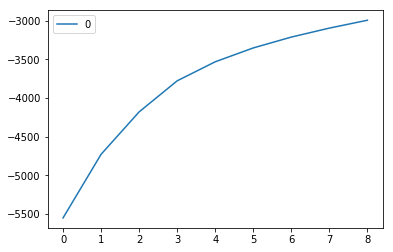

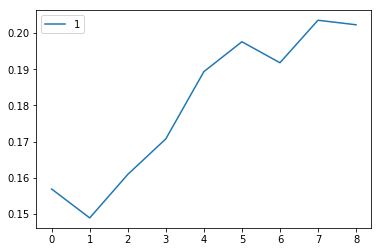

In [218]:
pd.DataFrame(clusters_scores)[[0]].plot(),
pd.DataFrame(clusters_scores)[[1]].plot()

In [219]:
clusters_scores

[(-5549.707769680422, 0.15690609169658593, 10),
 (-4726.982997161291, 0.14892753915444465, 20),
 (-4178.376460294012, 0.16093505679113376, 30),
 (-3776.714515284609, 0.1707563570005523, 40),
 (-3530.5054627187096, 0.1893317556358193, 50),
 (-3351.409327225314, 0.19759408407702203, 60),
 (-3211.0932437415104, 0.19179453714473466, 70),
 (-3094.957946801408, 0.20353422046244354, 80),
 (-2993.3331863945573, 0.20228456887642296, 90)]

In [100]:
clustering.score(X_new_lda)

-592.9953714344127

In [102]:
clustering.score(X_new_lda)

-563.2322182364401

In [221]:
comp = pd.DataFrame(new_data[['text', 'prediction']])

In [222]:
comp['clusters'] = clustering.predict(X_new_lda)

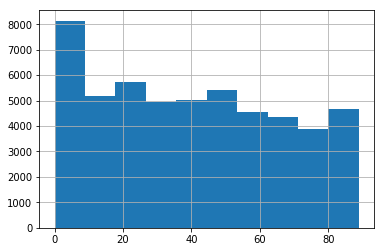

In [223]:
comp['clusters'].hist()

In [224]:
r = pd.pivot_table(comp, index='prediction', columns='clusters', aggfunc=len, fill_value=0)\
            .style.background_gradient(axis=1)

In [225]:
r

## Cluster label

In [67]:
new_data['cluster'] = clustering.predict(X_new_lda)

In [68]:
new_data.prediction.unique()

array(['alcohol', 'pain', 'drugAddiction', 'eatingDisorders', 'sleep',
       'infoPatient', 'pathology', 'treatment', 'incomprehension',
       'activity', 'agree', 'negativeEmo', 'risk', 'social', 'fallback',
       'smoking', 'positiveEmo', 'disagree'], dtype=object)

In [69]:
new_data[new_data.prediction == 'fallback']\
    .sort_values('proba', ascending=False)[['text', 'proba', 'clean_text', 'cluster']]

,text,proba,clean_text,cluster
123844,"BUT , it really helps if you keep reminding yourself that it 's only temporary ( a couple of months ) .",0.9,"[really, helps, keep, reminding, temporary, couple, months]",28
128601,I 'd really appreciate some input or experiences ... please ...,0.9,"[really, appreciate, input, experiences, please]",28
23383,You 'll need to keep the lights on though .,0.9,"[need, keep, lights, though]",28
61229,You really need to focus on WHY you 're drinking .,0.9,"[really, need, focus, drinking]",28
145472,"In fact , I 'm happier now as a person than I ever was before .",0.9,"[fact, happier, person, ever]",28
62488,arm yourself with information though bren .,0.9,"[arm, information, though, bren]",28
63871,\n\n Secondly its not as if I need a big wee .,0.9,"[secondly, need, big, wee]",28
59199,"I only posted a couple of times though , but I felt as if I knew everyone here .",0.9,"[posted, couple, times, though, felt, knew, everyone]",28
18448,Do you ever have shortness of breath ?,0.9,"[ever, shortness, breath]",28
17891,\n\n So now you need to take off the caretaker hat and put on the fishin ' hat .,0.9,"[need, take, caretaker, hat, put, fishin, hat]",28


In [72]:
new_data[new_data.cluster == 3]\
    .sort_values('proba', ascending=False)[['text', 'proba', 'clean_text', 'cluster', 'prediction']]

,text,proba,clean_text,cluster,prediction
48480,\n\n I know because I had a catherization at age 19 when I was freaking about my heart .,0.800,"[know, catherization, age, _num_, freaking, heart]",3,infoPatient
158417,My birthday is on the 22nd of Feb. \n\n It 's time to be healthy .,0.800,"[birthday, _num_nd, feb, time, healthy]",3,sleep
48182,I know how high the emotions can run as we go through this process .,0.800,"[know, high, emotions, run, go, process]",3,infoPatient
2719,"I know how difficult it is ( as the rest of the forum , otherwise we would n't be on it ) .",0.800,"[know, difficult, rest, forum, otherwise, would, nt]",3,infoPatient
74627,"I sit because of late stage diagnosis , or the cancer itself has this characteristic ?",0.775,"[sit, late, stage, diagnosis, cancer, characteristic]",3,sleep
47682,So I must go off now and wait for him to get back to me .,0.775,"[must, go, wait, get, back]",3,sleep
74153,Time to begin another day .,0.700,"[time, begin, another, day]",3,sleep
53239,\n I guess I just need to know if this is normal .,0.700,"[guess, need, know, normal]",3,infoPatient
125118,Today I begin to detox from this medication ( which is another story ) .,0.700,"[today, begin, detox, medication, another, story]",3,infoPatient
39521,\n I also know that health problems are more common with age .,0.700,"[also, know, health, problems, common, age]",3,drugAddiction


In [ ]:
new_data[new_data.proba>0.6][new_data.cluster == 22].groupby('prediction').mean()['proba'].sort_values(ascending=False)

In [ ]:
new_data[new_data.proba>0.2].groupby(['cluster', 'prediction']).sum()

In [ ]:
new_data[new_data.proba>0.2].groupby(['cluster', 'prediction']).count()['proba']#.sort_values(ascending=False)

In [ ]:
new_data[new_data.proba>0.8].groupby(['cluster', 'prediction']).count()['proba']#.plot(kind='box')

In [74]:
def filter_data(new_data, proba_threshold, population_threshold=None):
    by_proba = new_data[new_data.proba>proba_threshold]
    del by_proba['bow']
    del by_proba['lda_features']
    population = by_proba.groupby(['cluster', 'prediction']).count()['proba']
    if not population_threshold:
        population_threshold = int(population.mean())
    print(population_threshold)
    population = population.reset_index().groupby('cluster').max()
    clusters_to_leave = population[population.proba>population_threshold].index
    by_population = by_proba[by_proba.cluster.isin(clusters_to_leave)]
    
    new_labels = {}
    res = pd.DataFrame()
    
    for cluster_num in clusters_to_leave:
        new_labels[cluster_num] = by_population[by_population.cluster==cluster_num].groupby('prediction')\
            .sum()['proba'].sort_values().index[-1]
    
    by_population.loc[:, 'intent'] = by_population.loc[:, ('cluster')].apply(lambda x: new_labels[x])
    res = by_population.sort_values(['intent', 'proba'], ascending=False).groupby('intent').head(population_threshold)
    return res
    

In [277]:
res = filter_data(new_data, 0.1)

114


In [278]:
len(res.intent.unique())

20

In [279]:
res.groupby('intent').mean()['proba']

intent
activity           0.453158
agree              0.214320
alcohol            0.385310
bye                0.395968
disagree           0.297294
drugAddiction      0.512486
eatingDisorders    0.759617
fallback           0.193548
hello              0.315768
incomprehension    0.420925
infoPatient        0.632883
negativeEmo        0.406130
pain               0.950378
pathology          0.260361
positiveEmo        0.214056
risk               0.458883
sleep              0.586276
smoking            0.756109
social             0.426505
treatment          0.201239
Name: proba, dtype: float64

In [415]:
res.groupby('intent').head(3)

,clean_text,text,lens,prediction,proba,cluster,intent
156645,"[infrequent, incapacitating, degree, think, everything, body, connected]",It 's infrequent and not incapacitating to any degree .... but I do think that everything in our body is connected .,4,infoPatient,0.398418,39,treatment
27129,"[think, started, drink, heavily, _num_]",I think she only started to drink heavily when she was about 40 .,4,alcohol,0.325116,39,treatment
119173,"[wife, needs, help, love]",Your wife needs help and love !,3,pain,0.268553,39,treatment
91062,"[going, start, exercising, daily, see, goes]",I am going to start exercising daily and see where it goes from there .,3,alcohol,0.649604,67,social
70410,"[instead, drink, daily]",Instead I drink and not daily .,3,alcohol,0.647713,67,social
126106,"[gastros, make, drink, _num_, _num_, gal]",\n\n Most gastros make you drink 1/2 to 1 gal .,3,alcohol,0.643659,67,social
140539,"[smoke, _num_, _num_, cigarettes, day]",I only smoke between 3 to 6 cigarettes a day .,3,smoking,0.876583,73,smoking
11761,"[day, _num_, smoke, lifetime]",This is day 2 and I will not smoke again in my lifetime .,3,smoking,0.850125,73,smoking
62840,"[maybe, _num_, _num_, nightmares, month]",I now only have maybe 2 - 3 nightmares a month .,3,smoking,0.847492,73,smoking
147458,"[found, helps, sleep, _num_, _num_, wake]","I have found that helps , and I can sleep until 4 or 4:30 before I wake .",3,sleep,0.791832,6,sleep


## Iteration 1

In [280]:
data1 = res[['clean_text', 'text', 'intent']]

In [353]:
data1_ind = res.index

In [281]:
data1.index = pd.Index(list(range(len(data1))))

In [282]:
dictionary1 = Dictionary(documents=np.concatenate([data.clean_text.values,
                                                   data1.clean_text.values]))
print("Found {} words.".format(len(dictionary1.values())))

Found 3763 words.


In [283]:
data['bow'] = list(map(lambda doc: dictionary1.doc2bow(doc), data.clean_text))
data1['bow'] = list(map(lambda doc: dictionary1.doc2bow(doc), data1.clean_text))
corpus1 = np.concatenate([data.bow.values, data1.bow.values])

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [284]:
LDAmodel1 = LdaMulticore(corpus=corpus1,
                        id2word=dictionary1,
                        num_topics=400,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [285]:
data['lda_features'] = list(map(lambda doc:
                                  document_to_lda_features(LDAmodel1, doc),
                                  data.bow))

In [286]:
data1['lda_features'] = list(map(lambda doc:
                                  document_to_lda_features(LDAmodel1, doc),
                                  data1.bow))

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [287]:
gold_train_data = data.drop(gold_test_inx, errors="ignore")[['lda_features', 'intent']]
gold_test_data = data.loc[gold_test_inx][['lda_features', 'intent']]

In [306]:
gold_train_data.groupby('intent').count()

,lda_features
intent,
activity,130
agree,67
alcohol,69
bye,67
disagree,66
drugAddiction,152
eatingDisorders,111
fallback,65
hello,67


In [334]:
gold_X_train = np.array(list(map(np.array, gold_train_data.lda_features)))
gold_y_train = gold_train_data['intent']
gold_X_test = np.array(list(map(np.array, gold_test_data.lda_features)))
gold_y_test = gold_test_data['intent']

65
number of sampled example  1300 number of sample per class  65  #classes:  20
number of classes  20
True
Good all classes have the same number of examples


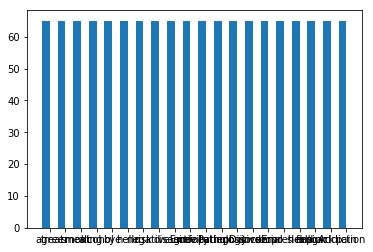

In [312]:
gold_X_train, gold_y_train, _, _ = balanced_sample_maker(gold_X_train, gold_y_train.values)

In [289]:
extra_X_train = np.array(list(map(np.array, data1.lda_features)))
extra_y_train = data1['intent']

In [335]:
X_train = np.concatenate([gold_X_train, extra_X_train])
y_train = np.concatenate([gold_y_train, extra_y_train])

In [336]:
Counter(y_train)

Counter({'alcohol': 183,
         'eatingDisorders': 225,
         'drugAddiction': 266,
         'smoking': 187,
         'treatment': 393,
         'sleep': 451,
         'infoPatient': 348,
         'pathology': 197,
         'pain': 341,
         'activity': 244,
         'incomprehension': 190,
         'negativeEmo': 197,
         'positiveEmo': 197,
         'fallback': 179,
         'social': 182,
         'agree': 181,
         'disagree': 180,
         'hello': 181,
         'bye': 181,
         'risk': 222})

In [314]:
clf1 = RandomForestClassifier().fit(X_train, y_train)

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [337]:
clf1 = SVC(kernel='linear', C=1, random_state=0, probability=True).fit(X_train, 
                                                                      y_train)

In [338]:
clf1.score(gold_X_test, gold_y_test)

0.2744186046511628

### CV scores

In [339]:
from sklearn.model_selection import cross_validate

In [340]:
scores = cross_validate(clf1, np.concatenate([gold_X_train, gold_X_test]), 
                                 np.concatenate([gold_y_train, gold_y_test]), 
                        scoring='accuracy', cv=5, return_estimator=False)

In [341]:
print('{:2.3} + {:2.3}%'.format(np.mean(scores['train_score']), np.std(scores['train_score'])))

0.424 + 0.00941%


/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [342]:
print('{:2.3} + {:2.3}%'.format(np.mean(scores['test_score']), np.std(scores['test_score'])))

0.383 + 0.0326%


### confusion

In [326]:
from sklearn.metrics import confusion_matrix

In [347]:
clf_res1 = pd.DataFrame([clf1.predict(gold_X_test), gold_y_test]).T
clf_res1.columns = ['class', 'intent']

In [348]:
cm = pd.DataFrame(confusion_matrix(clf_res1['intent'], clf_res1['class']), 
             index=clf1.classes_, columns=clf1.classes_)

In [349]:
cm.style.set_table_styles(
    [dict(selector="th",props=[('max-width', '120px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(180deg)'),
                        ])]
).background_gradient(axis=1)

,activity,agree,alcohol,bye,disagree,drugAddiction,eatingDisorders,fallback,hello,incomprehension,infoPatient,negativeEmo,pain,pathology,positiveEmo,risk,sleep,smoking,social,treatment
activity,18,0,0,0,0,1,0,0,0,0,4,0,4,0,0,1,6,2,0,7
agree,0,8,0,5,1,1,0,0,4,4,2,0,0,0,0,0,0,3,5,10
alcohol,3,0,15,0,2,3,1,0,0,1,4,0,1,0,0,9,3,1,0,0
bye,9,2,3,5,0,3,0,2,1,5,0,0,1,0,0,0,5,0,2,5
disagree,9,2,0,1,0,8,0,2,0,1,2,2,0,0,0,0,5,0,2,9
drugAddiction,2,0,0,3,0,17,5,1,0,1,2,0,0,1,0,0,4,4,0,3
eatingDisorders,1,0,1,0,5,1,14,0,0,3,5,6,0,0,1,1,2,1,2,0
fallback,6,0,1,0,0,7,1,1,2,4,1,0,0,0,0,0,4,0,1,15
hello,4,0,1,8,0,1,0,0,0,2,0,0,0,0,0,0,0,2,2,23
incomprehension,2,2,4,0,2,0,4,0,0,10,0,1,0,0,1,1,1,0,2,13


In [350]:
res.groupby('intent').mean()['proba'].sort_values()

intent
fallback           0.193548
treatment          0.201239
positiveEmo        0.214056
agree              0.214320
pathology          0.260361
disagree           0.297294
hello              0.315768
alcohol            0.385310
bye                0.395968
negativeEmo        0.406130
incomprehension    0.420925
social             0.426505
activity           0.453158
risk               0.458883
drugAddiction      0.512486
sleep              0.586276
infoPatient        0.632883
smoking            0.756109
eatingDisorders    0.759617
pain               0.950378
Name: proba, dtype: float64

## Preparation for iteration 2

In [356]:
new_data = new_data.drop(data1_ind, errors="ignore")

In [357]:
new_data['bow'] = list(map(lambda doc: dictionary1.doc2bow(doc), new_data.clean_text))

In [358]:
new_data['lens']= new_data.bow.apply(len)
new_data = new_data[new_data.lens>2]

In [359]:
len(new_data)

161579

In [360]:
new_data.index = pd.Index(list(range(len(new_data))))

In [361]:
new_data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel1, doc),
                                      new_data.bow))

In [362]:
X_new_lda = np.array(list(map(np.array, new_data.lda_features)))

In [363]:
new_data['prediction'] = clf1.predict(X_new_lda)
new_data['proba'] = clf1.predict_proba(X_new_lda).max(axis=1)

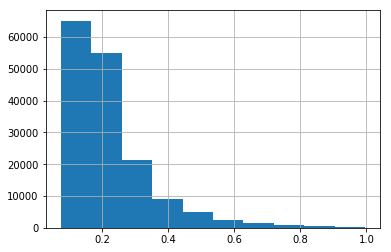

In [364]:
new_data.proba.hist()

In [365]:
new_data.sort_values('proba', ascending=False)[['text', 'proba', 'prediction', 'clean_text']]

,text,proba,prediction,clean_text
20486,I feel like I am reliving everything I blocked out .,0.996225,negativeEmo,"[feel, like, reliving, everything, blocked]"
79200,"\n\n Anxiety , I feel like a chainsaw .",0.996225,negativeEmo,"[anxiety, feel, like, chainsaw]"
109070,I feel like my life has been turned upside down .,0.993816,negativeEmo,"[feel, like, life, turned, upside]"
64454,That is OVER 1/2 a pound a day .,0.992144,eatingDisorders,"[_num_, pound, day]"
28402,"\n 3 ) Only use at night , so you can sleep .",0.991708,sleep,"[_num_, use, night, sleep]"
120503,\n How do you get access to 40 a day ?,0.988865,eatingDisorders,"[get, access, _num_, day]"
70732,I just wonder what it will feel like to feel normal again .,0.983724,negativeEmo,"[wonder, feel, like, feel, normal]"
116937,\n I am currently 5 feet 10 inches and weigh 140 .,0.981700,eatingDisorders,"[currently, _num_, feet, _num_, inches, weigh, _num_]"
28367,"I feel like the food is just SITTING there , like it 's not being digested at all .",0.979912,negativeEmo,"[feel, like, food, sitting, like, digested]"
105486,"How does the anxiety effect you , do you feel scared ?",0.976745,negativeEmo,"[anxiety, effect, feel, scared]"


In [366]:
new_data.prediction.unique()

array(['drugAddiction', 'eatingDisorders', 'sleep', 'hello', 'bye',
       'treatment', 'alcohol', 'incomprehension', 'infoPatient',
       'pathology', 'disagree', 'fallback', 'negativeEmo', 'agree',
       'social', 'smoking', 'pain', 'positiveEmo', 'activity', 'risk'],
      dtype=object)

In [367]:
set(data.intent.unique()) == set(new_data.prediction.unique())

True

In [368]:
new_data[new_data.prediction == 'pain']\
    .sort_values('proba', ascending=False)[['text', 'proba', 'clean_text']]

,text,proba,clean_text
21370,"Even if your in dire pain 1 - 3 a day should do it . """,0.965121,"[even, dire, pain, _num_, _num_, day]"
21364,Even if your in dire pain 1 - 3 a day should do it .,0.964435,"[even, dire, pain, _num_, _num_, day]"
93334,That 's around 8 - 10 a day .,0.945500,"[around, _num_, _num_, day]"
45710,Neck pain and shoulder pain \n 8 .,0.937371,"[neck, pain, shoulder, pain, _num_]"
152413,This part of my pain I feel is very separated from the pain you are feeling .,0.933435,"[part, pain, feel, separated, pain, feeling]"
20227,"And it leaves me in even more pain , around the left side of my abdoman .",0.931147,"[leaves, even, pain, around, left, side, abdoman]"
103088,It definitely took the pain out of my legs 80 % .,0.916622,"[definitely, took, pain, legs, _num_]"
158406,"She was in such incredible pain and , now , her life is turning around .",0.903216,"[incredible, pain, life, turning, around]"
159321,I reached my breaking point around 5 am .,0.902312,"[reached, breaking, point, around, _num_]"
66018,I feel the pain in my shoulder and back .,0.898340,"[feel, pain, shoulder, back]"


### Cluster new data

In [62]:
from sklearn.cluster import KMeans

In [64]:
from sklearn.metrics import silhouette_score

In [369]:
clustering = KMeans(85).fit(X_new_lda)

In [370]:
new_data['cluster'] = clustering.predict(X_new_lda)

In [380]:
res2 = filter_data(new_data, 0.005)

105


In [381]:
len(res2.intent.unique())

15

In [382]:
res2.groupby('intent').mean()['proba']

intent
activity           0.700769
agree              0.379874
alcohol            0.753332
bye                0.811251
disagree           0.762042
drugAddiction      0.661322
eatingDisorders    0.854917
incomprehension    0.475567
infoPatient        0.687442
negativeEmo        0.953919
pain               0.807351
sleep              0.853221
smoking            0.835241
social             0.557912
treatment          0.677126
Name: proba, dtype: float64

In [383]:
res2

,clean_text,text,lens,prediction,proba,cluster,intent
119852,"[take, zantac, _num_, think, reflux]",I take Zantac 75 because I think its reflux ?,4,treatment,0.849364,52,treatment
121526,"[turned, _num_, feel, like, _num_, lol]",I just turned 41 and I feel like I am 90 .... lol !,5,negativeEmo,0.835467,84,treatment
55392,"[hi, tazmin, think, depends, medical, records]","\n Hi Tazmin , \n\n I think it depends what is on your medical records .",3,treatment,0.818478,52,treatment
52792,"[_num_, reall, hard, get, _num_]",10 and it is reall hard to get it down to a 7 if at all .,3,eatingDisorders,0.816498,84,treatment
110311,"[man, post, brought, back, year, ago]","Man , your post brought me back to where I was a year ago .",5,smoking,0.792430,38,treatment
16230,"[decide, something, dont, think, future]","And , IF you decide to do something about it , don't think of the future !",5,treatment,0.788478,68,treatment
109455,"[say, hi, today]","All they had to say is "" hi , what are you doing today ? """,3,treatment,0.784125,38,treatment
13635,"[take, care, kadee, jkitty, hi, wanted, check]","\n take care \n kadee \n JKITTY : Hi there , just wanted to check in with you .",5,treatment,0.779113,68,treatment
78354,"[hi, name, christina, _num_, take, psych]","Hi my name is christina , i m only 20 , but take psych .",4,treatment,0.744825,84,treatment
99315,"[_num_, live, today]",\n 2 ) Live just for today .,3,treatment,0.742985,52,treatment


## Iteration 2

In [384]:
data2 = res2[['clean_text', 'text', 'intent']]

In [385]:
data2.index = pd.Index(list(range(len(data2))))

In [386]:
dictionary2 = Dictionary(documents=np.concatenate([data.clean_text.values,
                                                   data1.clean_text.values,
                                                   data2.clean_text.values]))
print("Found {} words.".format(len(dictionary2.values())))

Found 4690 words.


In [387]:
data['bow'] = list(map(lambda doc: dictionary2.doc2bow(doc), data.clean_text))
data1['bow'] = list(map(lambda doc: dictionary2.doc2bow(doc), data1.clean_text))
data2['bow'] = list(map(lambda doc: dictionary2.doc2bow(doc), data2.clean_text))
corpus2 = np.concatenate([data.bow.values, data1.bow.values, data2.bow.values])

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [388]:
LDAmodel2 = LdaMulticore(corpus=corpus2,
                        id2word=dictionary2,
                        num_topics=400,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [390]:
data['lda_features'] = list(map(lambda doc:
                                  document_to_lda_features(LDAmodel2, doc),
                                  data.bow))

In [391]:
data1['lda_features'] = list(map(lambda doc:
                                  document_to_lda_features(LDAmodel2, doc),
                                  data1.bow))

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [389]:
data2['lda_features'] = list(map(lambda doc:
                                  document_to_lda_features(LDAmodel2, doc),
                                  data2.bow))

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [392]:
gold_train_data = data.drop(gold_test_inx, errors="ignore")[['lda_features', 'intent']]
gold_test_data = data.loc[gold_test_inx][['lda_features', 'intent']]

In [393]:
gold_train_data.groupby('intent').count()

,lda_features
intent,
activity,130
agree,67
alcohol,69
bye,67
disagree,66
drugAddiction,152
eatingDisorders,111
fallback,65
hello,67


In [394]:
gold_X_train = np.array(list(map(np.array, gold_train_data.lda_features)))
gold_y_train = gold_train_data['intent']
gold_X_test = np.array(list(map(np.array, gold_test_data.lda_features)))
gold_y_test = gold_test_data['intent']

In [ ]:
gold_X_train, gold_y_train, _, _ = balanced_sample_maker(gold_X_train, gold_y_train.values)

In [395]:
extra1_X_train = np.array(list(map(np.array, data1.lda_features)))
extra1_y_train = data1['intent']

In [396]:
extra2_X_train = np.array(list(map(np.array, data2.lda_features)))
extra2_y_train = data2['intent']

In [397]:
X_train = np.concatenate([gold_X_train, extra1_X_train, extra2_X_train])
y_train = np.concatenate([gold_y_train, extra1_y_train, extra2_y_train])

In [398]:
Counter(y_train)

Counter({'alcohol': 288,
         'eatingDisorders': 330,
         'drugAddiction': 371,
         'smoking': 292,
         'treatment': 498,
         'sleep': 556,
         'infoPatient': 453,
         'pathology': 197,
         'pain': 446,
         'activity': 349,
         'incomprehension': 295,
         'negativeEmo': 302,
         'positiveEmo': 197,
         'fallback': 179,
         'social': 287,
         'agree': 286,
         'disagree': 285,
         'hello': 181,
         'bye': 286,
         'risk': 222})

In [399]:
clf2 = SVC(kernel='linear', C=1, random_state=0, probability=True).fit(X_train, 
                                                                      y_train)

In [401]:
clf2.score(gold_X_test, gold_y_test)

0.25465116279069766

### CV scores

In [339]:
from sklearn.model_selection import cross_validate

In [402]:
scores = cross_validate(clf2, np.concatenate([gold_X_train, gold_X_test]), 
                                 np.concatenate([gold_y_train, gold_y_test]), 
                        scoring='accuracy', cv=5, return_estimator=False)

In [403]:
print('{:2.3} + {:2.3}%'.format(np.mean(scores['train_score']), np.std(scores['train_score'])))

0.438 + 0.00898%


/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [404]:
print('{:2.3} + {:2.3}%'.format(np.mean(scores['test_score']), np.std(scores['test_score'])))

0.4 + 0.0346%


### confusion

In [326]:
from sklearn.metrics import confusion_matrix

In [406]:
clf_res2 = pd.DataFrame([clf1.predict(gold_X_test), gold_y_test]).T
clf_res2.columns = ['class', 'intent']

In [407]:
cm = pd.DataFrame(confusion_matrix(clf_res2['intent'], clf_res2['class']), 
             index=clf1.classes_, columns=clf1.classes_)

In [408]:
cm.style.set_table_styles(
    [dict(selector="th",props=[('max-width', '120px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(180deg)'),
                        ])]
).background_gradient(axis=1)

,activity,agree,alcohol,bye,disagree,drugAddiction,eatingDisorders,fallback,hello,incomprehension,infoPatient,negativeEmo,pain,pathology,positiveEmo,risk,sleep,smoking,social,treatment
activity,2,0,0,0,1,1,0,1,0,4,6,0,0,0,0,0,6,0,1,21
agree,6,0,4,1,2,0,1,0,0,0,4,0,0,0,0,0,1,1,3,20
alcohol,1,0,4,3,0,6,1,0,0,2,2,0,1,0,1,3,14,3,0,2
bye,13,0,1,3,0,3,0,1,0,1,5,0,0,0,0,0,5,4,0,7
disagree,12,0,0,1,0,9,0,0,0,1,5,0,3,0,0,0,0,2,1,9
drugAddiction,3,0,0,2,1,10,0,1,2,1,2,0,0,0,0,2,14,1,1,3
eatingDisorders,4,0,1,0,5,9,2,0,0,4,1,0,0,0,2,1,6,2,1,5
fallback,7,1,0,2,1,8,0,0,0,1,1,0,0,0,0,0,2,1,2,17
hello,12,0,6,1,0,2,0,0,0,1,2,0,0,0,0,0,4,0,0,15
incomprehension,15,0,0,6,4,3,0,0,1,0,0,0,0,0,0,0,9,0,2,3


In [409]:
res2.groupby('intent').mean()['proba'].sort_values()

intent
agree              0.379874
incomprehension    0.475567
social             0.557912
drugAddiction      0.661322
treatment          0.677126
infoPatient        0.687442
activity           0.700769
alcohol            0.753332
disagree           0.762042
pain               0.807351
bye                0.811251
smoking            0.835241
sleep              0.853221
eatingDisorders    0.854917
negativeEmo        0.953919
Name: proba, dtype: float64

In [413]:
pd.concat([data, data1,data2], sort=False)[['clean_text', 'intent', 'text']]

,clean_text,intent,text
0,"[drink, little, bottle, wine, day, week]",alcohol,I’m drinking at least a bottle of wine a day in the week
1,"[drink, six, ounce, vodka, average, per, day]",alcohol,I drink six ounces of vodka average per day
2,"[go, month, little, year, without, drink]",alcohol,I can go for months and at least a year or so without drinking
3,"[end, stage, alcohol, addiction]",alcohol,I'm in end stage of alcohol addiction
4,"[buy, four, pack, every, night, work]",alcohol,I do buy a four pack every night after work
5,"[try, stop, drink]",alcohol,I am trying to stop drinking
6,"[_num_, year, old, battle, alcohol, past, _num_, year]",alcohol,I’m 25 years old and I’ve been battling with alcohol for the past 5 years
7,"[drink, often, drink, know, limit]",alcohol,I don’t drink often but when I do drink I don’t know my limits
8,"[weekends, go, window, though, drink, much]",alcohol,"Weekends it all goes out of the window though, I drink too much"
9,"[_num_, month, clean, back, home]",alcohol,I’m now 2 months clean back home
